In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.3.0


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
!unzip "/content/gdrive/My Drive/Sem2/Project/train.zip" -d "./"

In [ ]:
!unzip "/content/gdrive/My Drive/Sem2/Project/test.zip" -d "./"

In [ ]:
trainDF = pd.read_csv("/content/gdrive/My Drive/Sem2/Project/train.txt", sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv("/content/gdrive/My Drive/Sem2/Project/test.txt", sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 
testDF['SteeringAngle'] = testDF['SteeringAngle'] * (pi / 180)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
trainData = trainDF.shape[0] * 0.75
valData = trainDF.shape[0] * 0.25
# print(trainData, valData)

test_datagen = ImageDataGenerator(rescale=1./255)

BatchSize = 98

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [ ]:
def ENetB4_FE(width, height, depth):

    conv_base = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 4, 7, 1792)        17673823  
_________________________________________________________________
flatten_11 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 1200)              60212400  
_________________________________________________________________
dropout_28 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 120)               144120    
_________________________________________________________________
dropout_29 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


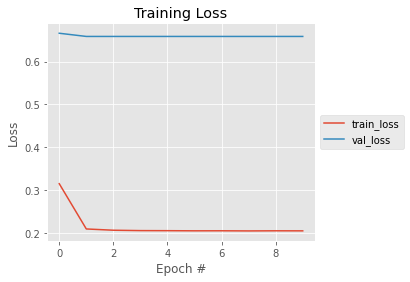

In [ ]:
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 10

model = ENetB4_FE(width=200, height=100, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1e-3), loss="mse")

filepath = "/content/gdrive/My Drive/Sem2/Project/VGG16/NewProposed/FE/VGG16_FE_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=round(trainData/BatchSize),
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=round(valData/BatchSize),
                callbacks=[checkpoint])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/content/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(100,200))

filepath = "/content/gdrive/My Drive/Sem2/Project/VGG16/NewProposed/FE/VGG16_FE_weights.10-0.66.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)

MAE = mean_absolute_error(testDF.iloc[:, -1], predictions)
print(MAE)

Found 8951 validated image filenames.
0.21958225906889167
